## build a kNN model to predict the close price of home

## Questions
* Using the dataset provided, please build a k-NN model for k = 4 that avoids time leakage.
* What is the performance of the model measured in Median Relative Absolute Error?
* Please select the optimal k given an appropriate methodology.
* Do you notice any spatial or temporal trends in error?
* How would you improve this model?

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

# preprocessing data
from sklearn.preprocessing import StandardScaler

# import models 
from sklearn.neighbors import KNeighborsRegressor

# use cross-validation
from sklearn.cross_validation import train_test_split, cross_val_score, KFold

# datetime 
from datetime import timedelta

In [2]:
# read the data
df = pd.read_csv('sample_sales.csv', parse_dates=['list_date', 'close_date'])

In [3]:
df.shape

(85548, 5)

In [4]:
df.head()

,latitude,longitude,list_date,close_date,close_price
0,36.344900,-97.745410,2013-07-30,2014-08-01,180000
1,36.325867,-98.704020,2013-12-04,2014-01-07,124900
2,36.397224,-97.730635,2013-11-25,2013-12-13,143250
3,36.188710,-98.370340,2013-12-10,2013-12-24,66650
4,36.688700,-98.147475,2013-12-10,2014-01-03,210000


In [5]:
df.describe()

,latitude,longitude,close_price
count,85548.000000,85548.000000,8.554800e+04
mean,34.575342,-93.576787,2.666583e+06
std,14.096439,31.131773,1.547636e+07
min,-89.985915,-179.921891,-9.998000e+04
25%,36.203080,-98.480120,1.150000e+05
50%,36.384527,-98.168405,1.710000e+05
75%,36.542446,-97.973845,2.720000e+05
max,89.989203,179.559607,1.009996e+08


## one question: close price of some data is negative. Is that meaningful? Should I remove these records?

In [6]:
df1 = df[df.close_price > 0]
df1.shape

(83454, 5)

In [7]:
df1.describe()

,latitude,longitude,close_price
count,83454.000000,83454.000000,8.345400e+04
mean,34.576793,-93.564453,2.734712e+06
std,14.101168,31.192332,1.566327e+07
min,-89.985915,-179.921891,1.000000e+00
25%,36.203114,-98.480127,1.190000e+05
50%,36.384389,-98.168285,1.750000e+05
75%,36.542009,-97.973856,2.750000e+05
max,89.989203,179.559607,1.009996e+08


## Q1: Using the dataset provided, please build a k-NN model for k = 4 that avoids time leakage.

* In this problem, neighbors is defined by spatial distance, which is the euclidean_distance (p=2 in KNeighborsRegressor)

* About weights of neighbors, they could be uniform or distance d. Here I choose distance, which mean weight is proportional to 1/d. (cross validation could be used to see which weigths meathod is better)

In [8]:
features = ['latitude', 'longitude', 'list_date', 'close_date']
label = ['close_price']
# save features into X and label into y
X = df1[features].values # numpy array
y = df1[label].ix[:, 0].values # 1d numpy array

In [9]:
X.shape, y.shape

((83454, 4), (83454,))

In [10]:
def train_knn(X_train, X_test, y_train, y_test, n_neighbors, weights):
    """train a KNN, make prediction and output error"""
    estimator = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=2)
    y_pred = []  
    errs = []
    
    for i in range(X_test.shape[0]): # for each data in testing 
    # for i in range(0, 50): # for each data in testing 
        # only use training data where close_date of training data is prior to list_date 
        index_prior = (X_train[:, 3] < X_test[i, 2]) 
        # print("size of training data after filtering", index_prior.sum())
        if (index_prior.sum() >= n_neighbors):
            estimator.fit(X_train[index_prior, :2], y_train[index_prior])
            y_pred_i = estimator.predict(X_test[i, :2])[0]
            # compute MRAE error
            err_i = np.abs(y_pred_i - y_test[i]) / y_test[i]
        else: # number of samples in training is less than number of neighbors, can not use KNN
            y_pred_i = np.nan
            err_i = np.nan
            # print('can not use KNN because number of samples is', index_prior.sum())

        # print(i, y_test[i], y_pred_i, err)
        y_pred.append(y_pred_i)
        errs.append(err_i)
        
    y_pred = np.array(y_pred)        
    errs = np.array(errs)    
    return y_pred, errs

## Q2: What is the performance of the model measured in Median Relative Absolute Error?
* Use cross validation to evaluate the performance of model
* Use MRAE as performance metric

In [11]:
def cv_score(X, y, n_neighbors=4, weights='distance', n_samples=X.shape[0]):
    """use K-fold to split data into training and testing, train model, and output MRAE"""
    MRAEs = []    
    print("number of samples:", n_samples)
    kf = KFold(n_samples, n_folds=3, random_state=1234)

    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # train knn 
        y_pred, errs = train_knn(X_train, X_test, y_train, y_test, n_neighbors, weights)
#         print(y_pred.shape, errs.shape)
        # compute MRAE
        MRAEs.append(np.median(errs))
    return(np.array(MRAEs))

In [517]:
%%time
MRAEs = cv_score(X, y, n_samples=40000)
print('MRAE:', MRAEs)
print('MRAE is between %.3f +/- %.3f' % (MRAEs.mean(), MRAEs.std()))

number of samples: 40000
MRAE: [ 0.32382954  0.26314384  0.39301352]
MRAE is between 0.327 +/- 0.053
CPU times: user 4min 33s, sys: 15.6 ms, total: 4min 33s
Wall time: 4min 33s


In [516]:
%%time
MRAEs = cv_score(X, y, n_samples=20000)
print('MRAE:', MRAEs)
print('MRAE is between %.3f +/- %.3f' % (MRAEs.mean(), MRAEs.std()))

number of samples: 20000
MRAE: [ 0.39626419  0.3742384   0.32861406]
MRAE is between 0.366 +/- 0.028
CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 4s


In [12]:
%%time
MRAEs = cv_score(X, y, n_samples=10000)
print('MRAE:', MRAEs)
print('MRAE is between %.3f +/- %.3f' % (MRAEs.mean(), MRAEs.std()))

number of samples: 10000
MRAE: [ 0.40969671  0.46956597  0.42099298]
MRAE is between 0.433 +/- 0.026
CPU times: user 19 s, sys: 3.22 ms, total: 19 s
Wall time: 19 s


## Q3: Please select the optimal k given an appropriate methodology.
* use cross validataion to select the optimal k, which is 2 (see the plot below)

In [14]:
%%time
n_neighbors_list = np.arange(1, 7)
MRAEs_list = []
for n_neighbors in n_neighbors_list:
    print('when n_neighbors:', n_neighbors)
    MRAEs = cv_score(X, y, n_neighbors)
    print('MRAE is between %.3f +/- %.3f \n' % (MRAEs.mean(), MRAEs.std()))
    MRAEs_list.append(MRAEs.mean())

when n_neighbors: 1
number of samples: 83454
MRAE is between 0.284 +/- 0.076 

when n_neighbors: 2
number of samples: 83454
MRAE is between 0.270 +/- 0.068 

when n_neighbors: 3
number of samples: 83454
MRAE is between 0.270 +/- 0.069 

when n_neighbors: 4
number of samples: 83454
MRAE is between 0.280 +/- 0.075 

when n_neighbors: 5
number of samples: 83454
MRAE is between 0.291 +/- 0.081 

when n_neighbors: 6
number of samples: 83454
MRAE is between 0.306 +/- 0.088 

CPU times: user 2h 35min 34s, sys: 496 ms, total: 2h 35min 34s
Wall time: 2h 35min 34s


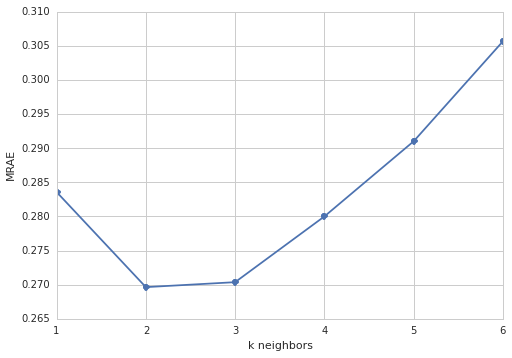

In [17]:
plt.plot(n_neighbors_list, MRAEs_list, 'bo-')
plt.xlabel("k neighbors")
plt.ylabel("MRAE")

## Q4: Do you notice any spatial or temporal trends in error?
* use the optimal k (k=2) to retrain the model
* plot the errors of predictions in spatial (heatmap) or in time 
* error is higher in the middle of year compared to beginning of year

In [16]:
%%time
# split X, y into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

y_pred, errs = train_knn(X_train, X_test, y_train, y_test, n_neighbors=2, weights='distance')
MRAE = np.median(errs)
print('MRAE: ', MRAE)

(62590, 4) (20864, 4) (62590,) (20864,)
MRAE:  0.248128389062
CPU times: user 7min 26s, sys: 23 ms, total: 7min 26s
Wall time: 7min 26s


In [17]:
errs.shape

(20864,)

In [18]:
y_pred.shape

(20864,)

In [19]:
X_test.shape

(20864, 4)

In [20]:
errs[:, np.newaxis].shape

(20864, 1)

In [21]:
np.hstack((X_test, errs[:, np.newaxis]))

array([[36.313988, -98.08033, Timestamp('2013-04-19 00:00:00'),
        Timestamp('2013-07-29 00:00:00'), 0.3398074657696694],
       [36.49362, -97.96319, Timestamp('2013-03-17 00:00:00'),
        Timestamp('2013-06-05 00:00:00'), 184.15669698284003],
       [36.335094, -98.10089, Timestamp('2013-04-03 00:00:00'),
        Timestamp('2013-06-05 00:00:00'), 7.399910191982032],
       ..., 
       [36.320071999999996, -98.03013, Timestamp('2013-04-22 00:00:00'),
        Timestamp('2013-10-04 00:00:00'), 0.28621667753867674],
       [36.5951, -98.04053, Timestamp('2013-08-15 00:00:00'),
        Timestamp('2013-10-04 00:00:00'), 0.07179195103549899],
       [36.587856, -98.005675, Timestamp('2013-03-01 00:00:00'),
        Timestamp('2013-04-23 00:00:00'), 0.2165974835343095]], dtype=object)

In [22]:
X_test_error = pd.DataFrame(np.hstack((X_test, errs[:, np.newaxis])), 
                            columns=['latitude', 'longitude', 'list_date', 'close_date', 'error'])
# remove np.nan values
X_test_error.dropna(inplace=True)

In [36]:
X_test_error.head()

,latitude,longitude,list_date,close_date,error,month
0,36.31399,-98.08033,2013-04-19 00:00:00,2013-07-29 00:00:00,0.3398075,4
1,36.49362,-97.96319,2013-03-17 00:00:00,2013-06-05 00:00:00,184.1567,3
2,36.33509,-98.10089,2013-04-03 00:00:00,2013-06-05 00:00:00,7.39991,4
3,36.33155,-98.01282,2013-06-21 00:00:00,2013-08-13 00:00:00,0.3530819,6
4,35.94355,-97.82439,2013-03-25 00:00:00,2013-08-19 00:00:00,0.9056037,3


In [24]:
X_test_error.describe()

,latitude,longitude,list_date,close_date,error
count,20645.00000,20645.000000,20645,20645,20645
unique,19343.00000,18972.000000,369,627,20614
top,36.30656,-98.078696,2013-05-24 00:00:00,2013-06-21 00:00:00,0
freq,16.00000,16.000000,129,222,9


In [35]:
X_test_error['month'] = X_test_error.list_date.dt.month

In [44]:
error_by_month = X_test_error.groupby('month')['error'].apply(np.mean)
error_by_month

month
1      7.068162
2     13.910615
3     13.546936
4     18.423141
5     22.741241
6     19.624415
7     21.326070
8     19.841366
9     18.871085
10    20.344898
11    26.934966
12    14.490346
Name: error, dtype: float64

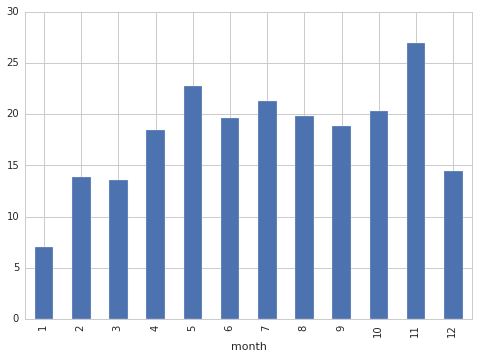

In [48]:
error_by_month.plot(kind='bar')

In [62]:
import gmaps

:0: FutureWarning: IPython widgets are experimental and may change in the future.


<IPython.core.display.Javascript object>

In [66]:
X_test_error['error1'] = X_test_error.error + 1e-12

In [67]:
X_test_error.error1.min()

1e-12

In [68]:
X_test_error.columns

Index(['latitude', 'longitude', 'list_date', 'close_date', 'error', 'month',
       'error1'],
      dtype='object')

In [70]:
X_test_error[['latitude', 'longitude', 'error1']].values

array([[36.313988, -98.08033, 0.3398074657706694],
       [36.49362, -97.96319, 184.15669698284103],
       [36.335094, -98.10089, 7.399910191983032],
       ..., 
       [36.320071999999996, -98.03013, 0.2862166775396767],
       [36.5951, -98.04053, 0.07179195103649899],
       [36.587856, -98.005675, 0.2165974835353095]], dtype=object)

In [71]:
w = gmaps.heatmap(X_test_error[['latitude', 'longitude', 'error1']].values)
gmaps.display(w)

## Q5: How would you improve this model?
* add time difference between list date as another feature to find K nearest neighbors
* since latitude and longtitude are difference scale compared to time difference, these features need to be normalized so that they are on the same scale. (zero mean and unit variace)
* retrain KNN using these three features 

In [519]:
df1.shape

(83454, 5)